### Mount drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Include library

In [62]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import joblib
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix


### Data processing

In [63]:
path = '/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1'
files = os.listdir(path)

In [64]:
image_files = random.sample(files, 9780)

In [65]:
input = []
target_age = []
for filename in image_files:
  if filename.endswith(".jpg"):
    actual_age = int(filename.split('_')[0])
    if actual_age >= 0 and actual_age <= 6:
      target_age.append(0)  # Trẻ em
    elif actual_age >= 7 and actual_age <= 19:
      target_age.append(1)  # Thiếu niên
    elif actual_age >= 20 and actual_age <=32 :
      target_age.append(2)  # Thanh niên
    elif actual_age >= 33 and actual_age <= 55:
      target_age.append(3)  # Trung niên
    else:  # actual_age >= 55
      target_age.append(4)  # Người cao tuổi
    input.append(path + '/' + filename)
  else:
    continue


In [66]:
print(len(target_age))

9780


In [67]:
age_counts = Counter(target_age)

print("Số lượng Trẻ em:", age_counts[0])
print("Số lượng Thiếu niên:", age_counts[1])
print("Số lượng Thanh niên:", age_counts[2])
print("Số lượng Trung niên:", age_counts[3])
print("Số lượng Người cao tuổi:", age_counts[4])


Số lượng Trẻ em: 2425
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [68]:
# Function to perform undersampling
def undersample(input_list, target_list, max_samples):
    indices = list(range(len(target_list)))
    random.shuffle(indices)
    sampled_indices = indices[:max_samples]
    return [input_list[i] for i in sampled_indices], [target_list[i] for i in sampled_indices]

In [69]:
# Determine the maximum number of samples per age group (e.g., 1000)
max_samples = 2000

# Create a balanced dataset
balanced_input = []
balanced_target_age = []
# Apply undersampling for each age group
for age_group in set(target_age):
    group_indices = [i for i, age in enumerate(target_age) if age == age_group]
    group_input = [input[i] for i in group_indices]
    group_target_age = [target_age[i] for i in group_indices]
    if len(group_target_age) > max_samples:
        group_input, group_target_age = undersample(group_input, group_target_age, max_samples)
    balanced_input.extend(group_input)
    balanced_target_age.extend(group_target_age)


In [70]:
age_counts = Counter(balanced_target_age)

print("Số lượng Trẻ em:", age_counts[0])
print("Số lượng Thiếu niên:", age_counts[1])
print("Số lượng Thanh niên:", age_counts[2])
print("Số lượng Trung niên:", age_counts[3])
print("Số lượng Người cao tuổi:", age_counts[4])

Số lượng Trẻ em: 2000
Số lượng Thiếu niên: 1739
Số lượng Thanh niên: 1864
Số lượng Trung niên: 1953
Số lượng Người cao tuổi: 1799


In [71]:
def process_image(img_file):
    try:
        img = cv2.imread(img_file)
        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 100)
        filename = os.path.basename(img_file)
        gender = int(filename.split('_')[1])
        return edges, gender
    except Exception as e:
        print(f"Error processing {img_file}: {e}")
        return None, None

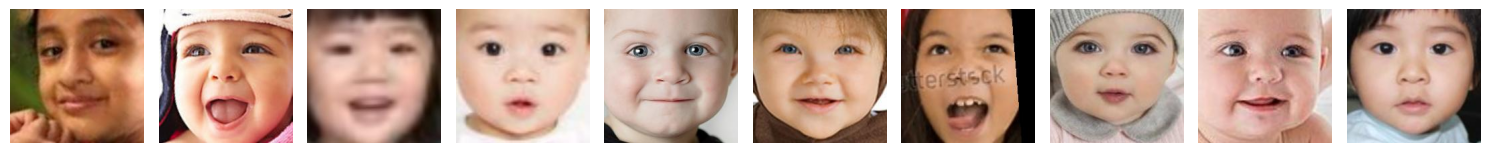

In [72]:
number_img = 10

fig, axes = plt.subplots(1, number_img, figsize=(15, 5))
for i, img_file in enumerate(balanced_input[0:number_img]):
    image_path = os.path.join(path, img_file)
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(rgb)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

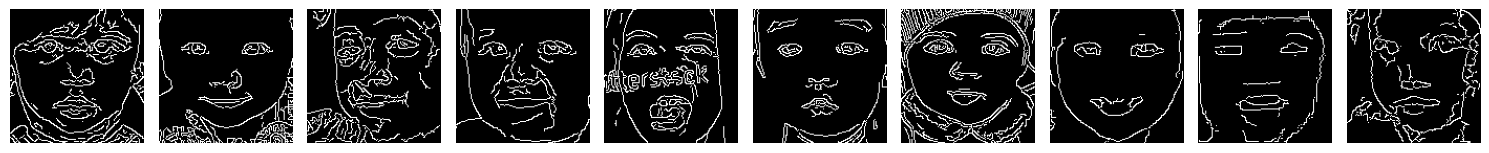

In [73]:
data = []
target_gender = []

# Number of images to visualize
number_img = 10
fig, axes = plt.subplots(1, number_img, figsize=(15, 5))

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_img = {executor.submit(process_image, img_file): img_file for img_file in balanced_input}
    for i, future in enumerate(as_completed(future_to_img)):
        img_canny, gender = future.result()
        if img_canny is not None:
            data.append(img_canny)
            target_gender.append(gender)
            # Display the first number_img images
            if i < number_img:
                axes[i].imshow(img_canny, cmap='gray')
                axes[i].axis('off')

plt.tight_layout()
plt.show()

In [74]:
data = np.array(data)
target_gender = np.array(target_gender)
target_age = np.array(balanced_target_age)

In [75]:
  print(f"shape of data: {data.shape}")
  print(f"shape of target age: {target_age.shape}")
  print(f"shape of target gender: {target_gender.shape}")
  print(target_gender)

shape of data: (9355, 128, 128)
shape of target age: (9355,)
shape of target gender: (9355,)
[0 0 1 ... 1 0 1]


### Visualizing Data

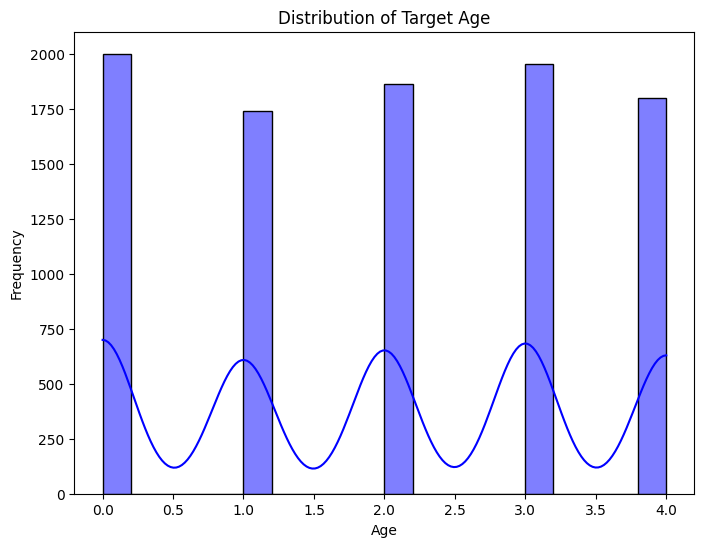

In [76]:
# Plotting target age
plt.figure(figsize=(8, 6))
sns.histplot(target_age, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

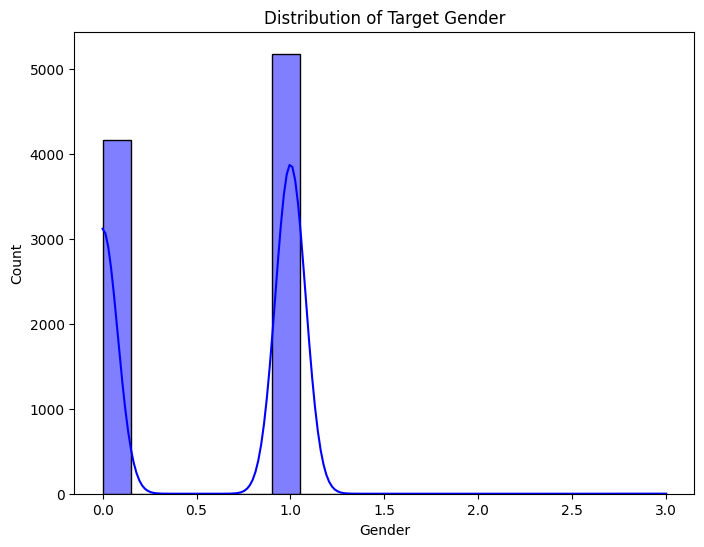

In [77]:
# Plotting target gender
plt.figure(figsize=(8, 6))
sns.histplot(target_gender, bins=20, kde=True, color='blue')
plt.title('Distribution of Target Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Split data

In [78]:
  # Split the data into train and test sets
  X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(data, target_gender, target_age, test_size=0.2, random_state=42)

  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

In [79]:
  print(f"shape of X train: {X_train.shape}")
  print(f"shape of X test: {X_test.shape}")
  print(f"shape of y train gender: {y_train_gender.shape}")
  print(f"shape of y test gender: {y_test_gender.shape}")
  print(f"shape of y train age: {y_train_age.shape}")
  print(f"shape of y test age: {y_test_age.shape}")

shape of X train: (7484, 16384)
shape of X test: (1871, 16384)
shape of y train gender: (7484,)
shape of y test gender: (1871,)
shape of y train age: (7484,)
shape of y test age: (1871,)


### Feature scaling


In [80]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PCA

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [82]:
X_train_pca.shape

(7484, 100)

### Train

#### SVM

In [83]:
#SVM
# Train the gender classifier
svm_gender = SVC()
svm_gender.fit(X_train_pca, y_train_gender)

# Train the age classifier
svm_age = SVC()
svm_age.fit(X_train_pca, y_train_age)
# Make predictions on the test set

y_pred_gender_svm = svm_gender.predict(X_test_pca)
y_pred_age_svm = svm_age.predict(X_test_pca)


#### KNN

In [84]:
from sklearn.neighbors import KNeighborsClassifier
#model age
model_knn_age = KNeighborsClassifier(n_neighbors=17, metric = "cosine")
model_knn_age.fit(X_train_pca, y_train_age)

# model gender
model_knn_gender = KNeighborsClassifier(n_neighbors=45, metric = "euclidean")
model_knn_gender.fit(X_train_pca, y_train_gender)
y_pred_age_knn = model_knn_age.predict(X_test_pca)
y_pred_gender_knn = model_knn_gender.predict(X_test_pca)

#### RF

In [85]:
from sklearn.ensemble import RandomForestClassifier

#Age model
rf_age = RandomForestClassifier()
rf_age.fit(X_train_pca, y_train_age)
#Gender model
rf_gender = RandomForestClassifier()
rf_gender.fit(X_train_pca, y_train_gender)

y_pred_age_rf = rf_age.predict(X_test_pca)
y_pred_gender_rf = rf_gender.predict(X_test_pca)

#### Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression

# Train the gender classifier
logistic_gender = LogisticRegression(solver='sag', max_iter=300, random_state=42)
logistic_gender.fit(X_train_pca, y_train_gender)

# Train the age classifier
logistic_age = LogisticRegression(solver='sag', max_iter=300, random_state=42)
logistic_age.fit(X_train_pca, y_train_age)

# Make predictions on the test set
y_pred_gender_lr = logistic_gender.predict(X_test_pca)
y_pred_age_lr = logistic_age.predict(X_test_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Evaluation

#### SVM

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gender, y_pred_gender_svm))
print(classification_report(y_test_age, y_pred_age_svm))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       815
           1       0.79      0.79      0.79      1056

    accuracy                           0.77      1871
   macro avg       0.76      0.76      0.76      1871
weighted avg       0.77      0.77      0.77      1871

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       401
           1       0.55      0.48      0.51       332
           2       0.56      0.58      0.57       393
           3       0.50      0.64      0.56       392
           4       0.73      0.55      0.63       353

    accuracy                           0.62      1871
   macro avg       0.63      0.61      0.62      1871
weighted avg       0.63      0.62      0.62      1871



In [88]:
#Get the confusion matrix
cf_matrix_gender_svm = confusion_matrix(y_test_gender, y_pred_gender_svm)
cf_matrix_age_svm = confusion_matrix(y_test_age, y_pred_age_svm)

<Axes: >

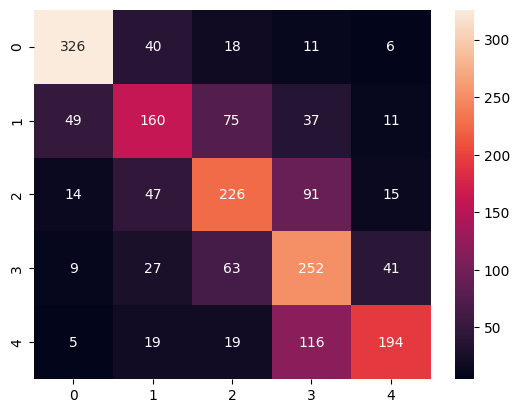

In [89]:
import seaborn as sns
sns.heatmap(cf_matrix_age_svm, annot=True, fmt='d')

<Axes: >

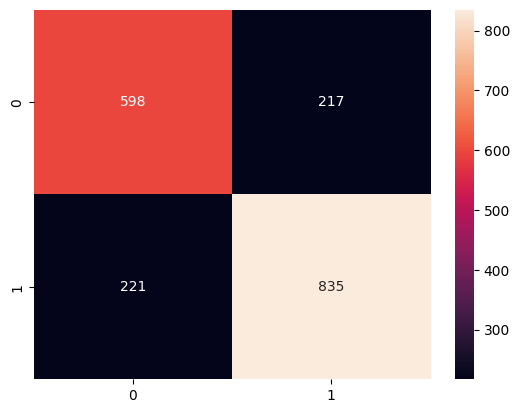

In [90]:
sns.heatmap(cf_matrix_gender_svm, annot=True, fmt='d')

#### LR

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gender, y_pred_gender_lr))
print(classification_report(y_test_age, y_pred_age_lr))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       815
           1       0.77      0.77      0.77      1056

    accuracy                           0.74      1871
   macro avg       0.73      0.74      0.73      1871
weighted avg       0.74      0.74      0.74      1871

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       401
           1       0.48      0.48      0.48       332
           2       0.54      0.51      0.52       393
           3       0.47      0.51      0.49       392
           4       0.62      0.59      0.60       353

    accuracy                           0.58      1871
   macro avg       0.58      0.58      0.58      1871
weighted avg       0.58      0.58      0.58      1871



In [92]:
#Get the confusion matrix
cf_matrix_gender_lr = confusion_matrix(y_test_gender, y_pred_gender_lr)
cf_matrix_age_lr = confusion_matrix(y_test_age, y_pred_age_lr)

<Axes: >

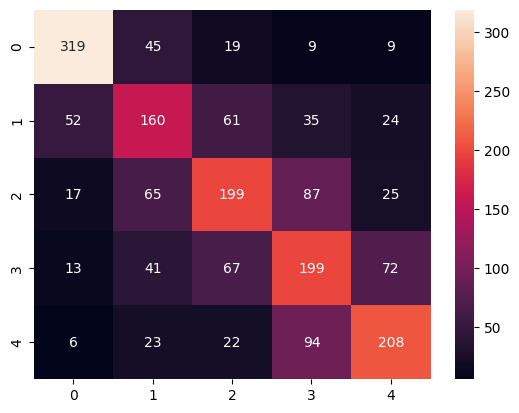

In [93]:
sns.heatmap(cf_matrix_age_lr, annot=True, fmt='d')

<Axes: >

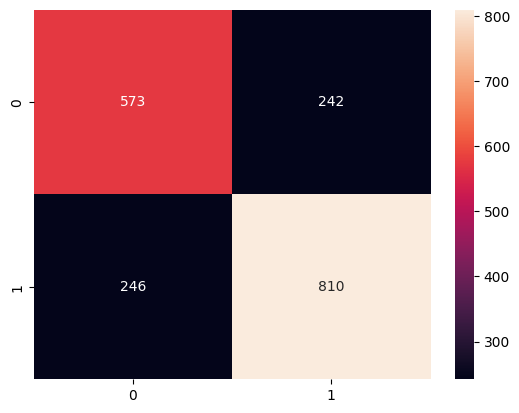

In [94]:
sns.heatmap(cf_matrix_gender_lr, annot=True, fmt='d')

#### RF

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gender, y_pred_gender_rf))
print(classification_report(y_test_age, y_pred_age_rf))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       815
           1       0.74      0.80      0.77      1056

    accuracy                           0.73      1871
   macro avg       0.73      0.72      0.72      1871
weighted avg       0.73      0.73      0.73      1871

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       401
           1       0.44      0.34      0.39       332
           2       0.46      0.48      0.47       393
           3       0.46      0.54      0.50       392
           4       0.63      0.48      0.55       353

    accuracy                           0.54      1871
   macro avg       0.54      0.53      0.53      1871
weighted avg       0.54      0.54      0.53      1871



In [96]:
#Get the confusion matrix
cf_matrix_gender_rf = confusion_matrix(y_test_gender, y_pred_gender_rf)
cf_matrix_age_rf = confusion_matrix(y_test_age, y_pred_age_rf)

<Axes: >

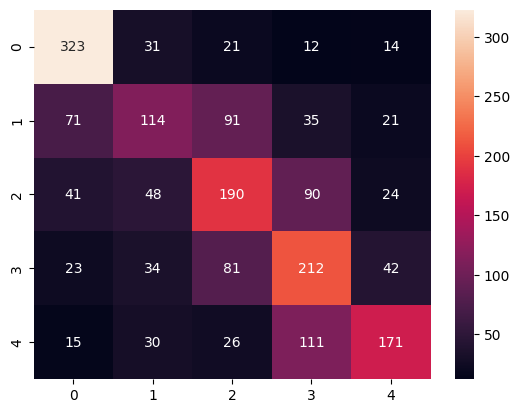

In [97]:
sns.heatmap(cf_matrix_age_rf, annot=True, fmt='d')

<Axes: >

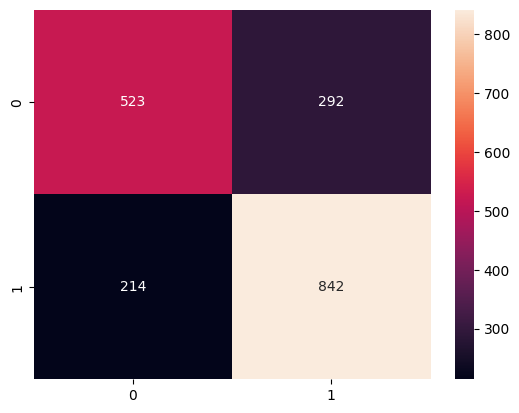

In [98]:
sns.heatmap(cf_matrix_gender_rf, annot=True, fmt='d')

#### KNN

In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test_gender, y_pred_gender_knn))
print(classification_report(y_test_age, y_pred_age_knn))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       815
           1       0.79      0.69      0.73      1056

    accuracy                           0.72      1871
   macro avg       0.72      0.72      0.72      1871
weighted avg       0.73      0.72      0.72      1871

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       401
           1       0.44      0.45      0.45       332
           2       0.53      0.42      0.47       393
           3       0.50      0.45      0.48       392
           4       0.57      0.54      0.55       353

    accuracy                           0.54      1871
   macro avg       0.53      0.54      0.53      1871
weighted avg       0.54      0.54      0.53      1871



In [100]:
#Get the confusion matrix
cf_matrix_gender_knn = confusion_matrix(y_test_gender, y_pred_gender_knn)
cf_matrix_age_knn = confusion_matrix(y_test_age, y_pred_age_knn)

<Axes: >

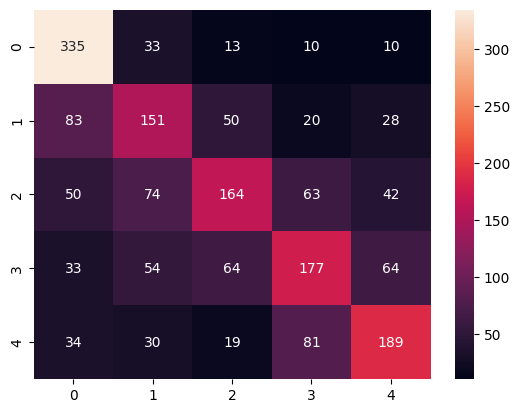

In [101]:
sns.heatmap(cf_matrix_age_knn, annot=True, fmt='d')

<Axes: >

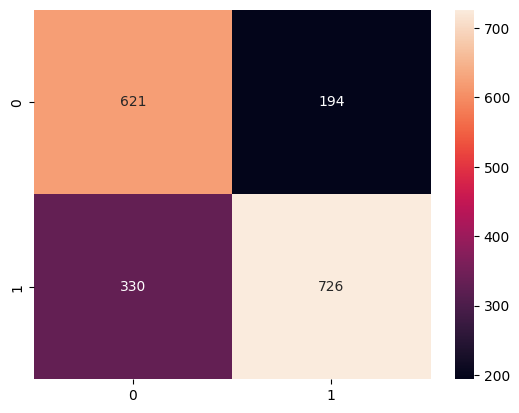

In [102]:
sns.heatmap(cf_matrix_gender_knn, annot=True, fmt='d')

#### Sum up

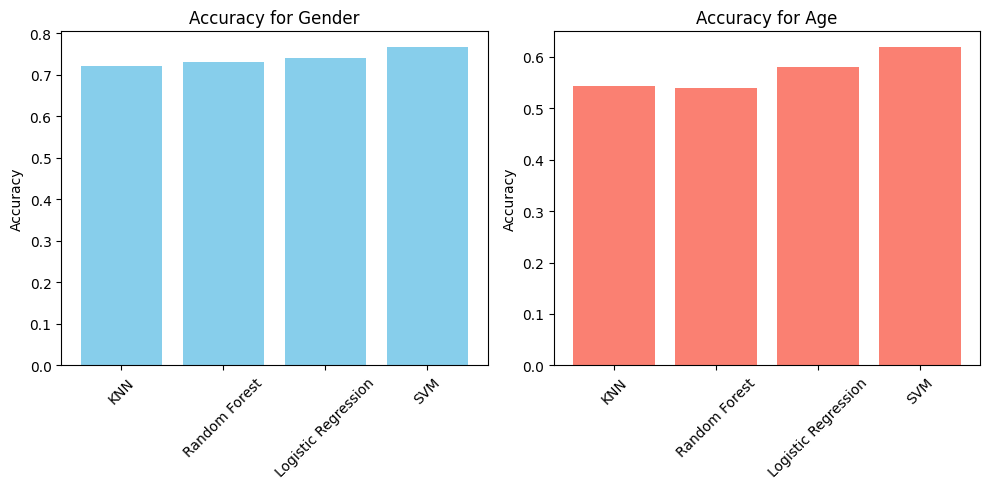

In [103]:

# Định nghĩa các mô hình đã đào tạo và dự đoán của chúng (y_pred_gender_knn, y_pred_age_knn, ...)
models = {
    "KNN": (y_pred_gender_knn, y_pred_age_knn),
    "Random Forest": (y_pred_gender_rf, y_pred_age_rf),
    "Logistic Regression": (y_pred_gender_lr, y_pred_age_lr),
    "SVM": (y_pred_gender_svm, y_pred_age_svm),  # Thay thế y_pred_gender_svm và y_pred_age_svm bằng dự đoán từ mô hình SVM của bạn
}

# Tính accuracy cho mỗi mô hình
accuracy_gender = {}
accuracy_age = {}

for model_name, (y_pred_gender, y_pred_age) in models.items():
    accuracy_gender[model_name] = np.mean(y_pred_gender == y_test_gender)
    accuracy_age[model_name] = np.mean(y_pred_age == y_test_age)

# Vẽ biểu đồ so sánh accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(accuracy_gender)), list(accuracy_gender.values()), align='center', color='skyblue')
plt.xticks(range(len(accuracy_gender)), list(accuracy_gender.keys()), rotation=45)
plt.title('Accuracy for Gender')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(range(len(accuracy_age)), list(accuracy_age.values()), align='center', color='salmon')
plt.xticks(range(len(accuracy_age)), list(accuracy_age.keys()), rotation=45)
plt.title('Accuracy for Age')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Demo

#### Function

In [104]:
def process_and_predict(file):
    img_origin = cv2.imread(file)
    if img_origin is None:
        raise ValueError(f"Image not found at path: {file}")

    img = cv2.resize(img_origin, (128, 128))

    # Convert BGR to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(gray, 100, 200)

    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assuming scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = svm_age.predict(img_canny)
    gender = svm_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-6', '7-19', '20-32', '33-55', '56+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()

In [105]:
import requests
from io import BytesIO
from PIL import Image

In [106]:
def process_and_predict_url(url):
    # Download image from URL
    response = requests.get(url)
    img_origin = Image.open(BytesIO(response.content))
    img_origin = cv2.cvtColor(np.array(img_origin), cv2.COLOR_RGB2BGR)

    img = cv2.resize(img_origin, (128, 128))

    # Convert BGR to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(gray, 100, 200)
    # Flatten and reshape for model input
    img_canny = img_canny.flatten().reshape(1, -1)

    # Scale the features (assuming scaler is already fitted on training data)
    img_canny = scaler.transform(img_canny)

    # Apply PCA for dimensionality reduction (assuming pca is already fitted on training data)
    img_canny = pca.transform(img_canny)

    # Predict age and gender
    age = svm_age.predict(img_canny)
    gender = svm_gender.predict(img_canny)

    # Interpret the results
    gender_label = 'male' if gender == 0 else 'female'
    age_labels = ['0-6', '7-19', '20-32', '33-55', '56+']
    age_label = age_labels[age[0]]

    # Display the original image with prediction results
    img_rgb = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f'Age: {age_label} \nGender: {gender_label}')
    plt.axis('off')
    plt.show()


#### Demo images

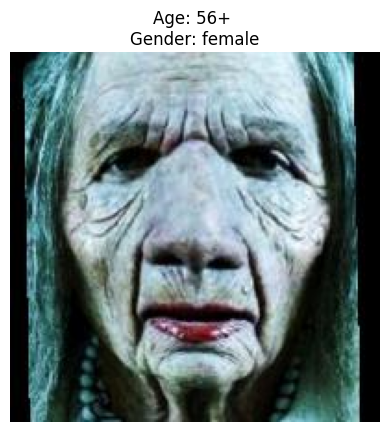

In [107]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/110_1_3_20170110155139762.jpg.chip.jpg')

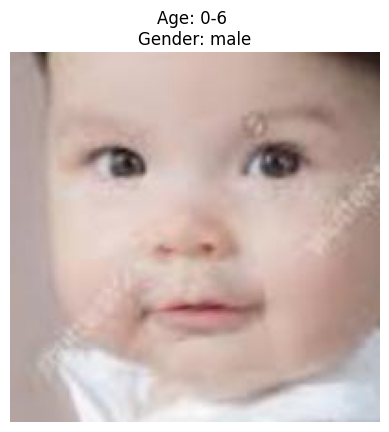

In [108]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Train/crop_part1/1_0_0_20161219140627985.jpg.chip.jpg')

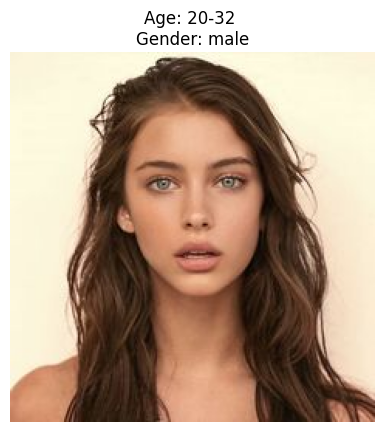

In [109]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Evaluate/7.jpg')


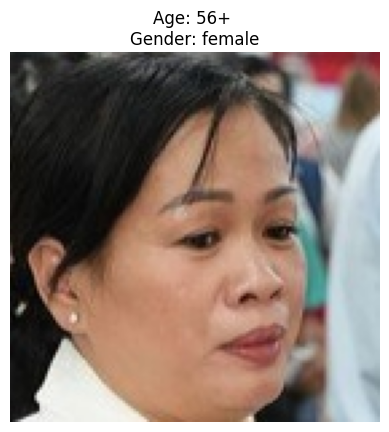

In [110]:
process_and_predict('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Test/img23.jpg')


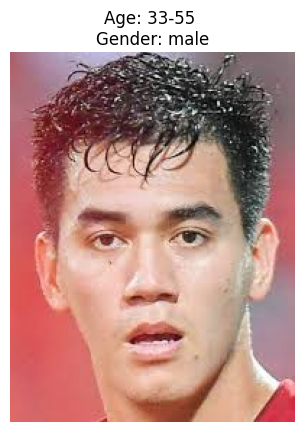

In [111]:
process_and_predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRq26ShHPCqw0aU1-3Wb0lu935LjK96je_An4ZiLmx1dQ&s')

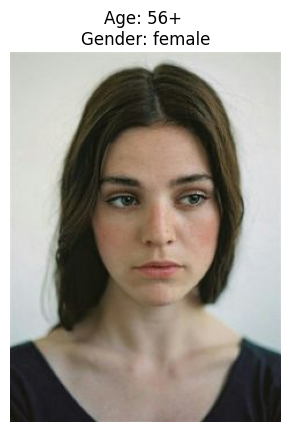

In [112]:
process_and_predict_url('https://i.pinimg.com/236x/d0/ec/7c/d0ec7c133990c5dd617a4e55239ee01a.jpg')

### Save model

In [128]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_KNN_Model_1.pkl"
joblib.dump(model_knn_age, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_KNN_Model_1.pkl']

In [127]:
joblib_file = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_KNN_Model_1.pkl"
joblib.dump(model_knn_gender, joblib_file)

['/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_KNN_Model_1.pkl']

In [115]:
# Load from file

Gender_model = joblib.load('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Age_SVM_Model.pkl')


Gender_model

SVC()

In [116]:
# Load from file

Age_model = joblib.load('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/Gender_SVM_Model.pkl')


Age_model

SVC()

In [117]:
# # Load from file

# scaler  = joblib.load('/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/scaler.pkl')


# scaler

In [118]:
# scaler_path = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/scaler.pkl"
# joblib.dump(scaler, scaler_path)

In [119]:
# pca_path = "/content/drive/MyDrive/CV_FinalProject/Source_code/Dataset/Pre-trained/pca.pkl"
# joblib.dump(pca, pca_path)